# Graphical visualization of z with LRP

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
import tensorflow as tf

In [4]:
import sys
from pathlib import Path
import_path = str(Path(os.getcwd()).parent.parent)
sys.path.insert(0, import_path)

from WorldModelsExperiments.breakout.model import Model, make_model, _process_frame

In [3]:
path = '/home/dakaun/Dropbox/MA/worldmodel/worldmodel-breakout-server-version-v3/200420'
rnn_path = path + '/tf_rnn/rnn.json'
vae_path = path + '/tf_vae/vae.json'
controller_path = path + '/log/breakout.cma.16.32.best.json'

render_mode = False
use_model = True

model = make_model(rnn_path=rnn_path, vae_path=vae_path)
model.load_model(controller_path)

INFO:tensorflow:Model using cpu.
loading file /home/dakaun/Dropbox/MA/worldmodel/worldmodel-breakout-server-version-v3/200420/log/breakout.cma.16.32.best.json


In [6]:
def simulate(model, train_mode=False, render_mode=True, num_episode=5, seed=-1, max_len=-1):
    reward_list = []
    t_list = []
    max_episode_length = 3000
    tsne_data = pd.DataFrame()    
    action_list = []#action_list_episode = []
    observation_list_episode = []
    reward_target = []
    
    if (seed >= 0):
        random.seed(seed)
        np.random.seed(seed)
        model.env.seed(seed)
    

    for episode in range(num_episode):
        #action_list = []
        observation_list = []
        obs = model.env.reset()
        if obs is None:
            obs = deepcopy(model.env.reset())
        #obs = _process_frame(obs)

        total_reward = 0.0

        for t in range(max_episode_length):
            if render_mode:
                model.env.render("human")
                model.env.unwrapped.viewer.window.on_key_press = key_press
                if RENDER_DELAY:
                    time.sleep(0.01)
            else:
                model.env.render('rgb_array')
            obs = _process_frame(obs)
            z, mu, logvar = model.encode_obs(obs)
            _, action = model.get_action(z)
            obs, reward, done, info = model.env.step(action)

            action_list.append(int(action))
            #observation_list.append(obs)
            #obs = _process_frame(obs)
            total_reward += reward
            #reward_target.append(int(reward))
            
            data = np.concatenate([z, model.state.h[0]]).reshape(1,288)
            #data = np.append(data, action).reshape(1,289)
            tsne_data = tsne_data.append(pd.DataFrame(data), ignore_index=True)

            if done:
                if render_mode:
                    model.env.close()
                #action_list_episode.append(np.array(action_list))
                #observation_list_episode.append(observation_list)
                break
        if render_mode:
            print("reward", total_reward, "timesteps", t)
        #reward_list.append(total_reward)
        #t_list.append(t)
    return action_list, tsne_data#, reward_target


In [7]:
actions, xtsne = simulate(model, train_mode=False, render_mode=False, num_episode=10)

In [18]:
actions = np.array(actions)

In [10]:
xtsne = np.array(xtsne)
xtsne.shape

(8047, 288)

In [11]:
model.weight.shape

(288, 4)

In [12]:
L_cont = 1

In [13]:
A_cont = [xtsne] + [None]*L_cont
A_cont[1] = np.maximum(0,A_cont[0].dot(model.weight)+model.bias)

In [14]:
A_cont[1][0].shape

(4,)

In [19]:
R_cont= [None]*L_cont + [A_cont[L_cont]*(actions[:,None]==np.arange(4))]

In [20]:
w = model.weight
wp = np.maximum(0,w)
wm = np.minimum(0,w)
lb = A_cont[0]*0-1
hb = A_cont[0]*0+1

z = A_cont[0].dot(w)-lb.dot(wp)-hb.dot(wm)+1e-9
s = R_cont[1]/z
c, cp, cm = s.dot(w.T), s.dot(wp.T), s.dot(wm.T)
R_cont[0] = A_cont[0]*c-lb*cp-hb*cm

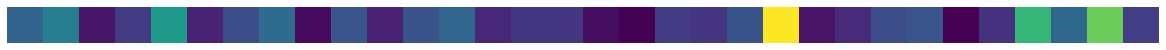

In [37]:
plt.figure(figsize=(16,5))
plt.subplots_adjust(left=0,right=1,bottom=0,top=1)
plt.axis('off')
plt.imshow(R_cont[0][:1,:32])
plt.show()

In [50]:
R_cont[0][:1,:32].shape

(1, 32)

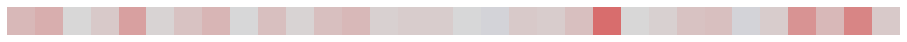

In [42]:
b = 10*((np.abs(R_cont[0][:1,:32])**3.0).mean()**(1.0/3))

from matplotlib.colors import ListedColormap
my_cmap = plt.cm.seismic(np.arange(plt.cm.seismic.N))
my_cmap[:,0:3] *= 0.85
my_cmap = ListedColormap(my_cmap)
plt.figure(figsize=(16,5))
plt.imshow(R_cont[0][:1,:32], cmap=my_cmap, vmin=-b, vmax=b)
plt.axis('off')
plt.show()